# Introduction to Argoverse-depth map

This is a simple tutorial that will show you how to interact with the Argoverse-tracking dataset and **create depth map for monocular depth estimation** using our python package. See [github page](https://github.com/argoai/argoverse-api) for instructions on how to install the package.

Argoverse dataset can be download at [https://www.argoverse.org](https://www.argoverse.org) This tutorial assumes that you already download and extract all neccessary data into a specific folder 

In [1]:
from matplotlib import pyplot as plt
import cv2
from tqdm import tqdm
import os
import glob
import numpy as np
from PIL import Image
import fnmatch

In [2]:
import argoverse
from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader

In [3]:
def extract_lidar_image_pair(idx, camera, argoverse_data):
    img = argoverse_data.get_image_sync(idx,camera = camera)
    
    objects = argoverse_data.get_label_object(idx)
    calib = argoverse_data.get_calibration(camera)

    pc = argoverse_data.get_lidar(idx)

    uv = calib.project_ego_to_image(pc).T

    idx_ = np.where(np.logical_and.reduce((uv[0, :] >= 0.0, uv[0, :] < np.shape(img)[1] - 1.0,
                                                          uv[1, :] >= 0.0, uv[1, :] < np.shape(img)[0] - 1.0,
                                                          uv[2, :] > 0)))
    idx_ = idx_[0]
    uv1 =uv[:, idx_]

    if uv1 is None:
        print('No point image projection')
        return
    else:
        return uv1, img

In [4]:
def save_images(uv1, img, dir_name, idx, camera, save_name):
    x_values = np.round(uv1[0], 0).astype(int)
    y_values = np.round(uv1[1], 0).astype(int)
    lidar_depth_val = uv1[2]
    blank_img = np.zeros([img.shape[0],img.shape[1]],dtype=np.uint16)

    for index in range(len(x_values)):
        try:
            blank_img[y_values[index], x_values[index]] = (lidar_depth_val[index])

        except:
            print(x_values[index],y_values[index], lidar_depth_val[i])
            pass
    
    paths = [os.path.join(save_name, 'depth', dir_name , str(camera)), 
             os.path.join(save_name, 'rgb', dir_name , str(camera))]
    for sub_path in paths:
        if not os.path.exists(sub_path):
            os.mkdir(sub_path)
    
    pred_depth_scaled = blank_img * 256.0
    pred_depth_scaled = pred_depth_scaled.astype(np.uint32)
    pred_depth_scaled = Image.fromarray(pred_depth_scaled)
    raw_depth_path = os.path.join(save_name, 'depth', dir_name , str(camera) , str(idx) + '.png')
    pred_depth_scaled.save(raw_depth_path)  
    
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    raw_img_path = os.path.join(save_name, 'rgb', dir_name , str(camera) , str(idx) + '.png')
    cv2.imwrite(raw_img_path, img_rgb, [cv2.IMWRITE_PNG_COMPRESSION, 0])    

In [12]:
def main(input_log_dir, output_save_path):
    dataset = os.path.dirname(input_log_dir)
    
    type_train = 'train'
    type_val = 'val'
    if fnmatch.fnmatchcase(input_log_dir, '*' +  type_train + '*'):
        save_name = os.path.join(output_save_path, 'train')
    elif fnmatch.fnmatchcase(input_log_dir, '*' +  type_val + '*'):
        save_name = os.path.join(output_save_path, 'val')
    log_id = os.path.basename(input_log_dir)
    print("Log ID ", log_id)
    
    # Create folder structure
    paths = [output_save_path, save_name, 
             os.path.join(save_name, 'depth'), 
             os.path.join(save_name, 'rgb'),
             os.path.join(save_name, 'depth', log_id), 
             os.path.join(save_name, 'rgb', log_id)
             ]
    for sub_path in paths:
        if not os.path.exists(sub_path):
            os.mkdir(sub_path)

    argoverse_loader = ArgoverseTrackingLoader(dataset)
    argoverse_data = argoverse_loader.get(log_id)
    
    pylCounter = len(glob.glob1(os.path.join(input_log_dir, 'lidar'), '*.ply'))  
    for i in tqdm(range(pylCounter)):
        cameras = argoverse_loader.CAMERA_LIST[0:6]
        for camera in cameras:
            lidar_data, front_img = extract_lidar_image_pair(i, camera, argoverse_data)
            save_images(lidar_data, front_img, log_id, i, camera, save_name)

## On sample data

In [13]:
folders = ['./Data/Argoverse/argoverse-tracking/train1/', 
           './Data/Argoverse/argoverse-tracking/train2/', 
           './Data/Argoverse/argoverse-tracking/train3/', 
           './Data/Argoverse/argoverse-tracking/train4/', 
           './Data/Argoverse/argoverse-tracking/val/']
output_save_path = './Data/Argoverse/sample_train_val/'

for folder in folders:
    subfolders = [ f.path for f in os.scandir(folder) if f.is_dir() ]
    for input_log_dir in subfolders:
        main(input_log_dir, output_save_path)  
        break  # Remove break to run on all the logids
    break  # Remove break to run on all the logids

Log ID  230970eb-dc2e-3133-b252-ff3c6f5d4284


100%|██████████| 157/157 [00:00<00:00, 540645.10it/s]


## Visualize

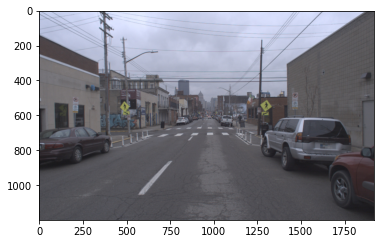

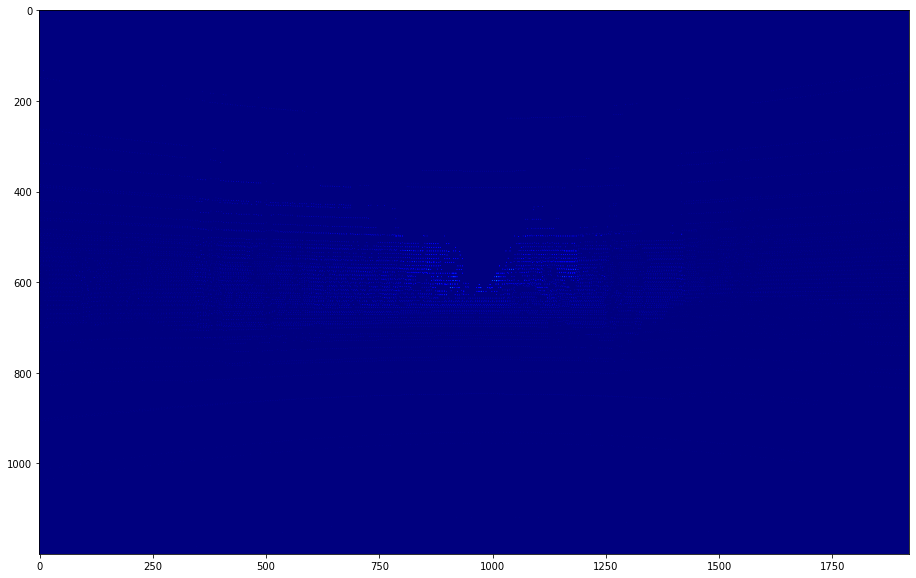

In [78]:
depth_image_path = './depth_data_all_cam/val/depth/5ab2697b-6e3e-3454-a36a-aba2c6f27818/ring_front_center/30.png'
rgb_image_path = './depth_data_all_cam/val/rgb/5ab2697b-6e3e-3454-a36a-aba2c6f27818/ring_front_center/30.png'

rgb_image = cv2.imread(rgb_image_path, -1)
rgb_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()

plt.figure(figsize=(20,10))
depth_image = cv2.imread(depth_image_path, -1)/256
plt.imshow(depth_image, cmap='jet')
plt.show()

## Genererate rgb to depth mapping for model training

In [81]:
rgb_path = "/depth_data_all_cam/train/rgb/"
depth_path = "/depth_data_all_cam/train/depth/"
myfile = open('argo_train_files_with_gt.txt', 'w')

for f in os.scandir(rgb_path):
    if f.is_dir():
        log_id = os.path.basename(f.path)
        find_path = os.path.join(f.path, "**/*.png")
        for file_name in glob.glob(find_path, recursive=True):
            path_log_cam, img_name = os.path.split(file_name)
            to_be_added_path = os.path.join(os.path.basename(path_log_cam), img_name)
            rgb_file_path = os.path.join(log_id, to_be_added_path)
            depth_file_path = os.path.join(depth_path, rgb_file_path)
            if os.path.isfile(depth_file_path) and os.access(depth_file_path, os.R_OK):
                gt_string = rgb_file_path + " " + rgb_file_path + " 1396.478"
                print(gt_string)
                myfile.write(gt_string+'\n')
            else:
                print("Either the file is missing or not readable")
            break # Remove break to run on all the logids
    break # Remove break to run on all the logids

cd5bb988-092e-396c-8f33-e30969c98535/ring_rear_left/228.png cd5bb988-092e-396c-8f33-e30969c98535/ring_rear_left/228.png 1396.478


# Now use the above data to train your monocular depth estimation model